Carga de imagenes
# Cargando imagenes

In [ ]:
import kagglehub
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import shutil
import numpy as np
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
#Imagenes para el entrenamiento
trains_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/breast',
    validation_split=0.2,
    subset = "training",
    seed=123,
    image_size=(224,224)
)

Found 7954 files belonging to 2 classes.
Using 6364 files for training.


In [ ]:
#Imagenes para la validacion
val_ds = tf.keras.utils.image_dataset_from_directory(
     '/content/drive/MyDrive/breast',
    validation_split=0.2,
    subset = "validation",
    seed=123,
    image_size=(224,224)
)

Found 7954 files belonging to 2 classes.
Using 1590 files for validation.


In [ ]:
#Aqui podemos verificar cuales son las clases de nuestro dataset
class_names = trains_ds.class_names
print(class_names)

['benign', 'malignant']


# Análisis exploratorio de los datos

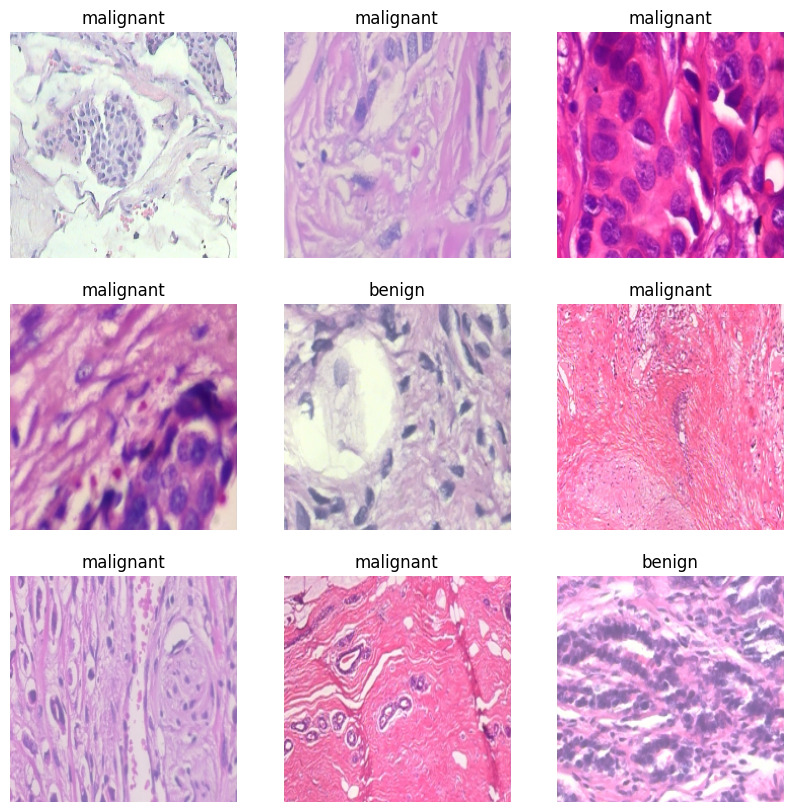

In [ ]:
#Vemos las imagenes
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in trains_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
#Vemos la distribucion de nuestros datos:
num_batches = tf.data.experimental.cardinality(trains_ds).numpy()
print(f'Numero de batches: {num_batches}')

total_images = 0 #Contador para el total de imagenes
imagenes_benigno = 0 #Contador para imagenes beningas
imagenes_maligno = 0 #Contador para imagenes malignas
num = 0
for images, labels in trains_ds:
  total_images += len(images)
  for i in range(len(images)):
    if class_names[labels[i]]=='benign':
      imagenes_benigno += 1
    else:
      imagenes_maligno += 1

print(f'Imagenes benignas: {imagenes_benigno}')
print(f'Imagenes malignas: {imagenes_maligno}')
print(f'Total de imagenes: {total_images}')

Numero de batches: 199
Imagenes benignas: 1976
Imagenes malignas: 4388
Total de imagenes: 6364


Porcentaje de imagenes benignas: 31.04965430546826
Porcentaje de imagenes malignas: 68.95034569453175


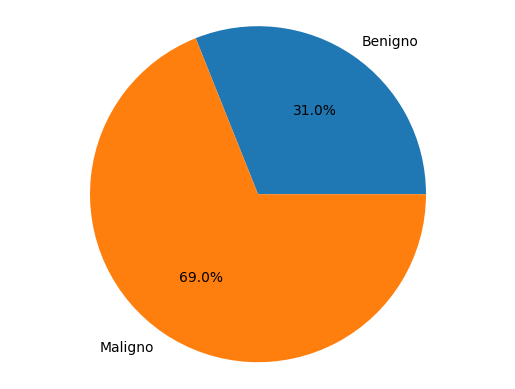

In [ ]:
#Para el entrenamiento
imagenes_beningnas =1976
imagenes_malignas = 4388
total_de_imagenes = 6364
porcentaje_benigno = (imagenes_beningnas/total_de_imagenes)*100
porcentaje_maligno = (imagenes_malignas/total_de_imagenes)*100
print(f'Porcentaje de imagenes benignas: {porcentaje_benigno}')
print(f'Porcentaje de imagenes malignas: {porcentaje_maligno}')

#Hacemos un histograma:
labels = ['Benigno', 'Maligno']
sizes = [porcentaje_benigno, porcentaje_maligno]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [ ]:
#Verificamos que el tamaño de las imagenes sea el correcto
for image_batch, labels_batch in trains_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# Creación de la red neuronal 1

Este fue el primer modelo que hicimos. El cual tiene tres capas convolucionales y tiene una función de perdida.

In [ ]:
#Creamos nuestro primer modelo
num_clases=len(class_names)

modelo_1 = Sequential([
 layers.Rescaling(1./255, input_shape=(224,224,3)),

 #Primera capa de convolucion:
 layers.Conv2D(16,3,padding='same',activation='relu'),
 layers.MaxPooling2D(),
 #Segunda capa convolucional:
 layers.Conv2D(32,3,padding='same',activation='relu'),
 layers.MaxPooling2D(),
 #Tercera capa convolucional:
 layers.Conv2D(64,3,padding='same',activation='relu'),
 layers.MaxPooling2D(),

 #Perdida
 layers.Dropout(0.2),
 #Aplanamos las dinemciones
 layers.Flatten(),

 #Red
 layers.Dense(128,activation='relu'),
 layers.Dense(num_clases)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Compilamos el modelo
modelo_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Vemos la estructura del modelo
modelo_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,446,498 (24.59 MB)

 Trainable params: 6,446,498 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo 1

In [ ]:
#Entrenamiento del modelo 1
epocas = 4
history = modelo_1.fit(
    trains_ds,
    validation_data=val_ds,
    epochs=epocas
)

Epoch 1/4
199/199 ━━━━━━━━━━━━━━━━━━━━ 663s 3s/step - accuracy: 0.6972 - loss: 0.8637 - val_accuracy: 0.7736 - val_loss: 0.5287
Epoch 2/4
199/199 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.7858 - loss: 0.4700 - val_accuracy: 0.8308 - val_loss: 0.4405
Epoch 3/4
199/199 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.8227 - loss: 0.4340 - val_accuracy: 0.8447 - val_loss: 0.3956
Epoch 4/4
199/199 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.8308 - loss: 0.4102 - val_accuracy: 0.8566 - val_loss: 0.4097


# Evaluacion del modelo 1

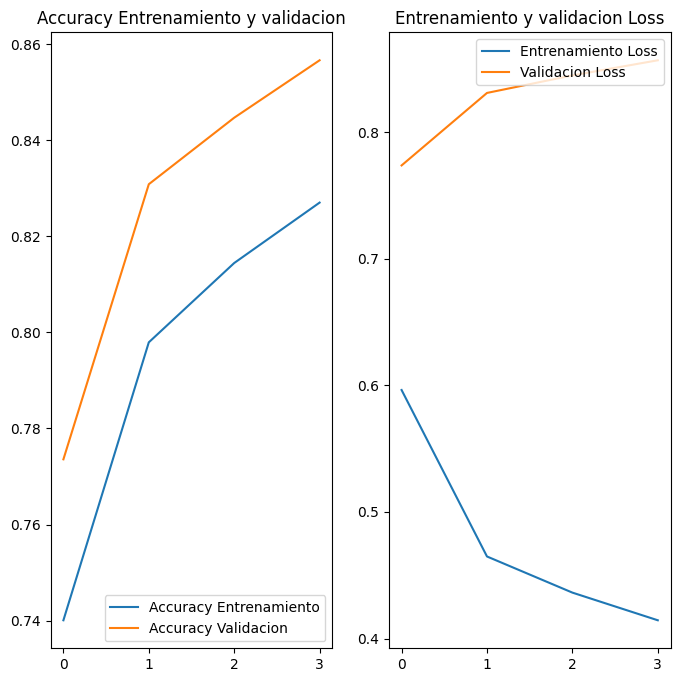

In [ ]:
#Visualizamos el rendimiento del modelo 1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epocas)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy Entrenamiento')
plt.plot(epochs_range,val_acc,label='Accuracy Validacion')
plt.legend(loc='lower right')
plt.title('Accuracy Entrenamiento y validacion')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Entrenamiento Loss')
plt.plot(epochs_range,val_acc,label='Validacion Loss')
plt.legend(loc='upper right')
plt.title('Entrenamiento y validacion Loss')
plt.show()



In [ ]:
#Evaluamos el modelo con la metrica Recall
test_loss, test_recall = modelo_1.evaluate(val_ds)
print(f"Test recall: {test_recall:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8575 - loss: 0.4052
Test recall: 0.8566


In [ ]:
#Cargamos uuna imagen para realizar una prediccion
imagen_path = '/content/drive/MyDrive/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png'
imagen = tf.keras.preprocessing.image.load_img(imagen_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(imagen)
input_arr = np.array([input_arr])
predictions = modelo_1.predict(input_arr)

#Imprimimos la prediccion
score = tf.nn.softmax(predictions[0])
print(
    "Esta imagen parece ser {} con un {:.2f} % de exactitud."
    .format(class_names[np.argmax(score)],100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Esta imagen parece ser benign con un 84.25 % de exactitud.


In [ ]:
#Cargamos uuna imagen para realizar una prediccion
imagen_path = '/content/drive/MyDrive/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-001.png'
imagen = tf.keras.preprocessing.image.load_img(imagen_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(imagen)
input_arr = np.array([input_arr])
predictions = modelo_1.predict(input_arr)

#Imprimimos la prediccion
score = tf.nn.softmax(predictions[0])
print(
    "Esta imagen parece ser {} con un {:.2f} % de exactitud."
    .format(class_names[np.argmax(score)],100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Esta imagen parece ser malignant con un 55.43 % de exactitud.


In [ ]:
# Guardamos el modelo
modelo_1.save('/content/drive/MyDrive/cancer_modelo_1.h5')

# Creamos la red neuronal 2


Este fue el segundo modelo que hicimos. El cual tiene tres capas convolucionales y tiene una función de perdida.

In [ ]:
#Creamos nuestro segundo modelo
num_clases=len(class_names)

modelo_2 = Sequential([
 layers.Rescaling(1./255, input_shape=(224,224,3)),

 #Primera capa de convolucion:
 layers.Conv2D(32,3,padding='same',activation='relu'),
 layers.MaxPooling2D(2,2),
 #Segunda capa convolucional:
 layers.Conv2D(32,3,padding='same',activation='relu'),
 layers.MaxPooling2D(2,2),
 #Tercera capa convolucional:
 layers.Conv2D(64,3,padding='same',activation='relu'),
 layers.MaxPooling2D(2,2),

 #Perdida
 layers.Dropout(0.5),
 #Aplanamos las dinemciones
 layers.Flatten(),

 #Red
 layers.Dense(128,activation='relu'),
 layers.Dense(num_clases)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Compilamos el modelo
modelo_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Vemos la estructura del modelo
modelo_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,451,554 (24.61 MB)

 Trainable params: 6,451,554 (24.61 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo 2

In [ ]:
#Entrenamiento del modelo 1
epocas = 4
history = modelo_2.fit(
    trains_ds,
    validation_data=val_ds,
    epochs=epocas
)

Epoch 1/4
199/199 ━━━━━━━━━━━━━━━━━━━━ 1230s 6s/step - accuracy: 0.7104 - loss: 0.7570 - val_accuracy: 0.8465 - val_loss: 0.4198
Epoch 2/4
199/199 ━━━━━━━━━━━━━━━━━━━━ 710s 4s/step - accuracy: 0.8057 - loss: 0.4567 - val_accuracy: 0.8478 - val_loss: 0.4059
Epoch 3/4
199/199 ━━━━━━━━━━━━━━━━━━━━ 740s 4s/step - accuracy: 0.8279 - loss: 0.4269 - val_accuracy: 0.8585 - val_loss: 0.4289
Epoch 4/4
199/199 ━━━━━━━━━━━━━━━━━━━━ 743s 4s/step - accuracy: 0.8284 - loss: 0.4228 - val_accuracy: 0.8553 - val_loss: 0.3784


#Evaluamos el modelo 2

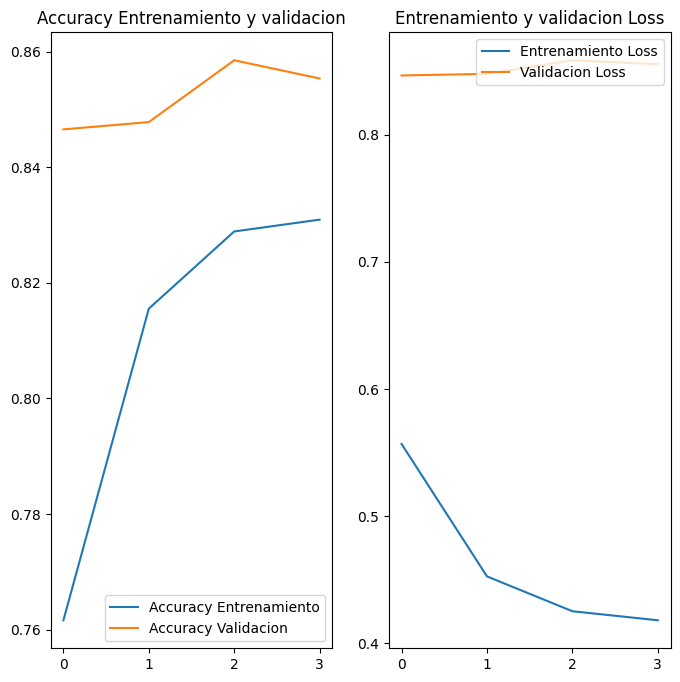

In [ ]:
#Visualizamos el rendimiento del modelo 1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epocas)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy Entrenamiento')
plt.plot(epochs_range,val_acc,label='Accuracy Validacion')
plt.legend(loc='lower right')
plt.title('Accuracy Entrenamiento y validacion')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Entrenamiento Loss')
plt.plot(epochs_range,val_acc,label='Validacion Loss')
plt.legend(loc='upper right')
plt.title('Entrenamiento y validacion Loss')
plt.show()

In [ ]:
#Evaluamos el modelo con la metrica Recall
test_loss, test_recall = modelo_2.evaluate(val_ds)
print(f"Test recall: {test_recall:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8565 - loss: 0.3724
Test recall: 0.8553


In [ ]:
#Cargamos uuna imagen para realizar una prediccion
imagen_path = '/content/drive/MyDrive/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-001.png'
imagen = tf.keras.preprocessing.image.load_img(imagen_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(imagen)
input_arr = np.array([input_arr])
predictions = modelo_2.predict(input_arr)

#Imprimimos la prediccion
score = tf.nn.softmax(predictions[0])
print(
    "Esta imagen parece ser {} con un {:.2f} % de exactitud."
    .format(class_names[np.argmax(score)],100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Esta imagen parece ser malignant con un 79.59 % de exactitud.


In [ ]:
# Guardamos el modelo
modelo_2.save('/content/drive/MyDrive/cancer_modelo_2.h5')

#Creación de la red neuronal 3


In [ ]:
#Creamos nuestro tercer modelo
num_clases=len(class_names)

modelo_3 = Sequential([
 layers.Rescaling(1./255, input_shape=(224,224,3)),

 #Primera capa de convolucion:
 layers.Conv2D(64,3,padding='same',activation='relu'),
 layers.MaxPooling2D(),
 #Segunda capa convolucional:
 layers.Conv2D(64,3,padding='same',activation='relu'),
 layers.MaxPooling2D(),
 #Tercera capa convolucional:
 layers.Conv2D(64,3,padding='same',activation='relu'),
 layers.MaxPooling2D(),

 #Perdida
 layers.Dropout(0.4),
 #Aplanamos las dinemciones
 layers.Flatten(),

 #Red
 layers.Dense(128,activation='relu'),
 layers.Dense(num_clases)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Compilamos el modelo
modelo_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Vemos la estructura del modelo
modelo_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,498,562 (24.79 MB)

 Trainable params: 6,498,562 (24.79 MB)

 Non-trainable params: 0 (0.00 B)

#Entrenamiento del modelo 3

In [ ]:
#Entrenamiento del modelo 1
epocas = 6
history = modelo_3.fit(
    trains_ds,
    validation_data=val_ds,
    epochs=epocas
)

Epoch 1/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 1380s 7s/step - accuracy: 0.6804 - loss: 0.8110 - val_accuracy: 0.8415 - val_loss: 0.4627
Epoch 2/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 1404s 7s/step - accuracy: 0.8015 - loss: 0.4698 - val_accuracy: 0.8522 - val_loss: 0.4166
Epoch 3/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 1344s 7s/step - accuracy: 0.8321 - loss: 0.4207 - val_accuracy: 0.8572 - val_loss: 0.4341
Epoch 4/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 1342s 7s/step - accuracy: 0.8352 - loss: 0.4179 - val_accuracy: 0.8465 - val_loss: 0.4126
Epoch 5/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 1328s 7s/step - accuracy: 0.8457 - loss: 0.3976 - val_accuracy: 0.8660 - val_loss: 0.3693
Epoch 6/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 1389s 7s/step - accuracy: 0.8544 - loss: 0.3785 - val_accuracy: 0.8497 - val_loss: 0.4201


#Evaluamos el modelo 3


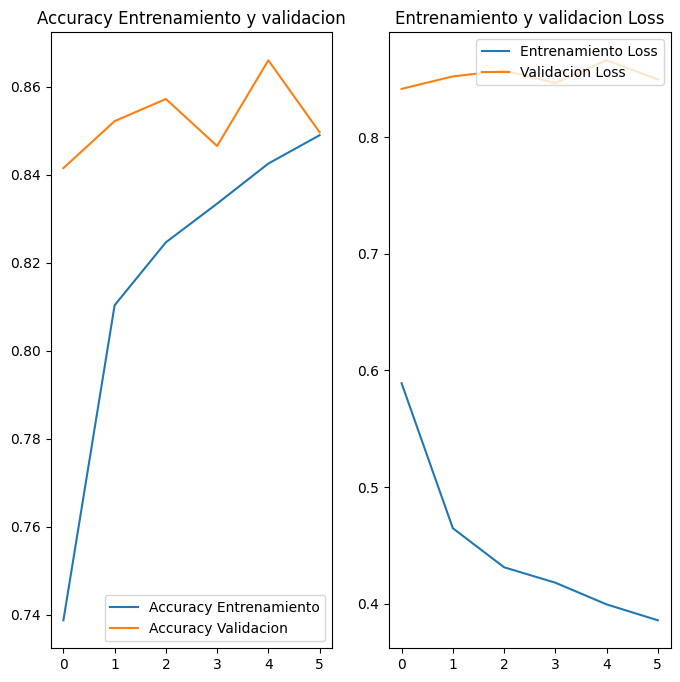

In [ ]:
#Visualizamos el rendimiento del modelo 3
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epocas)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy Entrenamiento')
plt.plot(epochs_range,val_acc,label='Accuracy Validacion')
plt.legend(loc='lower right')
plt.title('Accuracy Entrenamiento y validacion')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Entrenamiento Loss')
plt.plot(epochs_range,val_acc,label='Validacion Loss')
plt.legend(loc='upper right')
plt.title('Entrenamiento y validacion Loss')
plt.show()

In [ ]:
#Evaluamos el modelo con la metrica Recall
test_loss, test_recall = modelo_3.evaluate(val_ds)
print(f"Test recall: {test_recall:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8430 - loss: 0.4261
Test recall: 0.8497


In [ ]:
#Cargamos uuna imagen para realizar una prediccion
imagen_path = '/content/drive/MyDrive/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-001.png'
imagen = tf.keras.preprocessing.image.load_img(imagen_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(imagen)
input_arr = np.array([input_arr])
predictions = modelo_3.predict(input_arr)

#Imprimimos la prediccion
score = tf.nn.softmax(predictions[0])
print(
    "Esta imagen parece ser {} con un {:.2f} % de exactitud."
    .format(class_names[np.argmax(score)],100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Esta imagen parece ser malignant con un 54.89 % de exactitud.


In [ ]:
# Guardamos el modelo
modelo_3.save('/content/drive/MyDrive/cancer_modelo_3.h5')

# Modelo 4

In [ ]:
#Creamos nuestro cuarto modelo
num_clases=len(class_names)

modelo_4 = Sequential([

 layers.Rescaling(1./255, input_shape=(224,224,3)),

 #Primera capa de convolucion:
 layers.Conv2D(64,3,padding='same',activation='relu'),
 layers.MaxPooling2D(),
 #Perdida
 layers.Dropout(0.2),
 #Segunda capa convolucional:
 layers.Conv2D(64,3,padding='same',activation='relu'),
 layers.MaxPooling2D(),

 #Perdida
 layers.Dropout(0.2),
 #Aplanamos las dinemciones
 layers.Flatten(),
 #Red
 layers.Dense(64,activation='relu'),
 layers.Dense(num_clases)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Compilamos el modelo
modelo_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Vemos la estructura del modelo
modelo_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      12,845,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,651,912 (147.45 MB)

 Trainable params: 12,883,970 (49.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,767,942 (98.30 MB)

In [ ]:
epocas = 8
history = modelo_4.fit(
    trains_ds,
    validation_data=val_ds,
    epochs=epocas
)

Epoch 1/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1187s 6s/step - accuracy: 0.7743 - loss: 0.4966 - val_accuracy: 0.7748 - val_loss: 0.4944
Epoch 2/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1214s 6s/step - accuracy: 0.7904 - loss: 0.4687 - val_accuracy: 0.8327 - val_loss: 0.4397
Epoch 3/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1213s 6s/step - accuracy: 0.8199 - loss: 0.4393 - val_accuracy: 0.8409 - val_loss: 0.4642
Epoch 4/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1169s 6s/step - accuracy: 0.8317 - loss: 0.4261 - val_accuracy: 0.8421 - val_loss: 0.4320
Epoch 5/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1262s 6s/step - accuracy: 0.8350 - loss: 0.4127 - val_accuracy: 0.8497 - val_loss: 0.4205
Epoch 6/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1183s 6s/step - accuracy: 0.8420 - loss: 0.3912 - val_accuracy: 0.8484 - val_loss: 0.4024
Epoch 7/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1221s 6s/step - accuracy: 0.8432 - loss: 0.3884 - val_accuracy: 0.8497 - val_loss: 0.3957
Epoch 8/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1219s 6s/step - accuracy: 0.8570 - loss: 0.3555 - val_accu

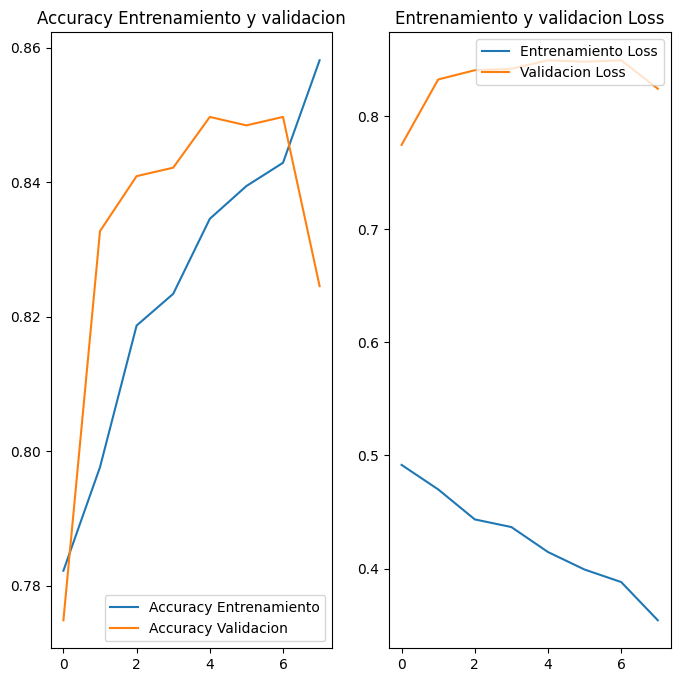

In [ ]:
#Visualizamos el rendimiento del modelo 3
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epocas)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy Entrenamiento')
plt.plot(epochs_range,val_acc,label='Accuracy Validacion')
plt.legend(loc='lower right')
plt.title('Accuracy Entrenamiento y validacion')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Entrenamiento Loss')
plt.plot(epochs_range,val_acc,label='Validacion Loss')
plt.legend(loc='upper right')
plt.title('Entrenamiento y validacion Loss')
plt.show()

In [ ]:
#Evaluamos el modelo con la metrica Recall
test_loss, test_recall = modelo_4.evaluate(val_ds)
print(f"Test recall: {test_recall:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8257 - loss: 0.4307
Test recall: 0.8245


In [ ]:
#Cargamos uuna imagen para realizar una prediccion
imagen_path = '/content/drive/MyDrive/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-001.png'
imagen = tf.keras.preprocessing.image.load_img(imagen_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(imagen)
input_arr = np.array([input_arr])
predictions = modelo_4.predict(input_arr)

#Imprimimos la prediccion
score = tf.nn.softmax(predictions[0])
print(
    "Esta imagen parece ser {} con un {:.2f} % de exactitud."
    .format(class_names[np.argmax(score)],100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Esta imagen parece ser malignant con un 76.69 % de exactitud.


In [ ]:
# Guardamos el modelo
modelo_4.save('/content/drive/MyDrive/cancer_modelo_4.h5')